<a href="https://colab.research.google.com/github/anurag25/shared_notebooks/blob/master/plant_pathology_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!ls "/content/drive/My Drive/kaggle/input/plant_data/images" | wc -l 

3642


In [0]:
!nvidia-smi

Sat May  9 06:22:07 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate, accuracy

In [0]:
import warnings
warnings.filterwarnings('ignore')

In [0]:
device = torch.cuda.set_device(0)
torch.cuda.get_device_properties(device)

_CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15079MB, multi_processor_count=40)

In [0]:
torch.cuda.empty_cache()

In [0]:
bs = 64

In [0]:
path_img = Path("/content/drive/My Drive/kaggle/input/plant_data/images")
path_ano = Path("/content/drive/My Drive/kaggle/input/plant_data/")
path_out = Path("/content/drive/My Drive/kaggle/working/")
print(str(len(path_img.ls())) + " iamges in image directory")
print(path_out.ls())
path_ano.ls()

3642 iamges in image directory
[]


[PosixPath('/content/drive/My Drive/kaggle/input/plant_data/images'),
 PosixPath('/content/drive/My Drive/kaggle/input/plant_data/sample_submission.csv'),
 PosixPath('/content/drive/My Drive/kaggle/input/plant_data/test.csv'),
 PosixPath('/content/drive/My Drive/kaggle/input/plant_data/train.csv')]

In [0]:
images = get_image_files(path_img)
print(len(images))

3642


In [0]:
df = pd.read_csv(path_ano/"train.csv")
df['image_id'] = df['image_id'] +".jpg"
#num = 0 * df.healthy + 1 * df.multiple_diseases + 2 * df.rust + 3 * df.scab
df['label'] = 0 * df.healthy + 1 * df.multiple_diseases + 2 * df.rust + 3 * df.scab

for i in range(len(df)):
    num = df.label[i]
    if num == 0:
        df.label[i] = 'healthy'
    if num == 1:
        df.label[i] = 'multiple_diseases'
    if num == 2:
        df.label[i] = 'rust'
    if num == 3:
        df.label[i] = 'scab'

df.drop(columns = ['healthy', 'multiple_diseases', 'rust', 'scab'], inplace = True)
print(df.head())
#data = data.label_from_df(['label'])

      image_id              label
0  Train_0.jpg               scab
1  Train_1.jpg  multiple_diseases
2  Train_2.jpg            healthy
3  Train_3.jpg               rust
4  Train_4.jpg            healthy


In [0]:
test_df = pd.read_csv(path_ano/"test.csv")
test_df["image_id"] = test_df["image_id"] + ".jpg"
test_df.head()
test_data = ImageList.from_df(test_df, path_img)
test_data

ImageList (1821 items)
Image (3, 1365, 2048),Image (3, 1365, 2048),Image (3, 1365, 2048),Image (3, 1365, 2048),Image (3, 1365, 2048)
Path: /content/drive/My Drive/kaggle/input/plant_data/images

In [0]:
data = ImageList.from_df(df, path_img)
data

ImageList (1821 items)
Image (3, 1365, 2048),Image (3, 1365, 2048),Image (3, 1365, 2048),Image (3, 1365, 2048),Image (3, 1365, 2048)
Path: /content/drive/My Drive/kaggle/input/plant_data/images

In [0]:
data = data.split_by_rand_pct(seed = 42)

In [0]:
data = data.label_from_df(['label'])
#['healthy', 'multiple_diseases', 'rust', 'scab']
data

LabelLists;

Train: LabelList (1457 items)
x: ImageList
Image (3, 1365, 2048),Image (3, 1365, 2048),Image (3, 1365, 2048),Image (3, 1365, 2048),Image (3, 1365, 2048)
y: CategoryList
scab,multiple_diseases,healthy,rust,healthy
Path: /content/drive/My Drive/kaggle/input/plant_data/images;

Valid: LabelList (364 items)
x: ImageList
Image (3, 1365, 2048),Image (3, 1365, 2048),Image (3, 1365, 2048),Image (3, 1365, 2048),Image (3, 1365, 2048)
y: CategoryList
rust,healthy,healthy,rust,healthy
Path: /content/drive/My Drive/kaggle/input/plant_data/images;

Test: None

In [0]:
ds_tfms = get_transforms(do_flip = True, flip_vert =True, max_rotate = 90.0, max_zoom =1.5, max_lighting =0.4, max_warp =0.4, p_affine = 0.75, p_lighting =0.75)
data = data.transform(ds_tfms, size = 224)
data

LabelLists;

Train: LabelList (1457 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
scab,multiple_diseases,healthy,rust,healthy
Path: /content/drive/My Drive/kaggle/input/plant_data/images;

Valid: LabelList (364 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
rust,healthy,healthy,rust,healthy
Path: /content/drive/My Drive/kaggle/input/plant_data/images;

Test: None

In [0]:
data = data.add_test(test_data)
data

LabelLists;

Train: LabelList (1457 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
scab,multiple_diseases,healthy,rust,healthy
Path: /content/drive/My Drive/kaggle/input/plant_data/images;

Valid: LabelList (364 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
rust,healthy,healthy,rust,healthy
Path: /content/drive/My Drive/kaggle/input/plant_data/images;

Test: LabelList (1821 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: /content/drive/My Drive/kaggle/input/plant_data/images

In [0]:
data = data.databunch( bs = bs)

In [0]:
data = data.normalize(imagenet_stats)

In [0]:
data

ImageDataBunch;

Train: LabelList (1457 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
scab,multiple_diseases,healthy,rust,healthy
Path: /content/drive/My Drive/kaggle/input/plant_data/images;

Valid: LabelList (364 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
rust,healthy,healthy,rust,healthy
Path: /content/drive/My Drive/kaggle/input/plant_data/images;

Test: LabelList (1821 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: /content/drive/My Drive/kaggle/input/plant_data/images

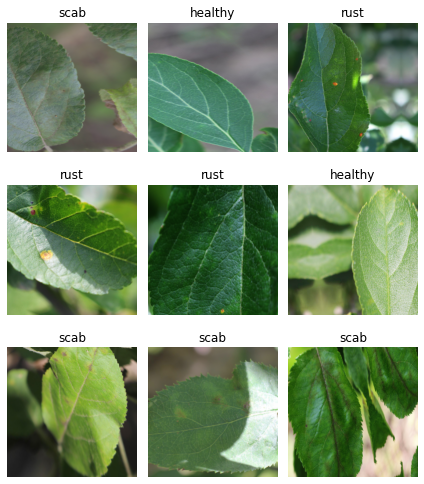

In [0]:
data.show_batch(rows=3, figsize=(6, 7))

In [0]:
#x,y = data.one_batch()

In [0]:
learn = cnn_learner(data, models.resnet152, metrics = [accuracy, error_rate])

In [0]:
%%time 
learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.212864,0.509813,0.854396,0.145604,02:13
1,0.971223,0.670963,0.846154,0.153846,02:16
2,0.781222,0.481170,0.873626,0.126374,02:16
3,0.647558,0.335981,0.903846,0.096154,02:15
4,0.544221,0.258512,0.914835,0.085165,02:15
5,0.458167,0.253241,0.931319,0.068681,02:14
6,0.412948,0.245109,0.939560,0.060440,02:14
7,0.376572,0.248979,0.934066,0.065934,02:14


CPU times: user 1min 30s, sys: 55.3 s, total: 2min 25s
Wall time: 18min


In [0]:
learn.model_dir = path_out

In [0]:
learn.save("stage_1")

In [0]:
learn.unfreeze()
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.469452,0.534442,0.914835,0.085165,02:17


In [0]:
learn.load("stage_1")

Learner(data=ImageDataBunch;

Train: LabelList (1457 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
scab,multiple_diseases,healthy,rust,healthy
Path: /content/drive/My Drive/kaggle/input/plant_data/images;

Valid: LabelList (364 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
rust,healthy,healthy,rust,healthy
Path: /content/drive/My Drive/kaggle/input/plant_data/images;

Test: LabelList (1821 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: /content/drive/My Drive/kaggle/input/plant_data/images, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): R

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 4.79E-06
Min loss divided by 10: 1.58E-05


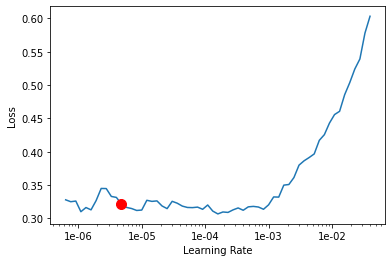

In [0]:
learn.recorder.plot(suggestion=True)

In [0]:
learn.unfreeze()

In [0]:
%%time
learn.fit_one_cycle(3, max_lr=slice(4e-5,1e-4))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.331624,0.245158,0.917582,0.082418,02:18
1,0.278129,0.271615,0.934066,0.065934,02:17
2,0.250421,0.260192,0.934066,0.065934,02:18


CPU times: user 45.2 s, sys: 29.1 s, total: 1min 14s
Wall time: 6min 55s


True


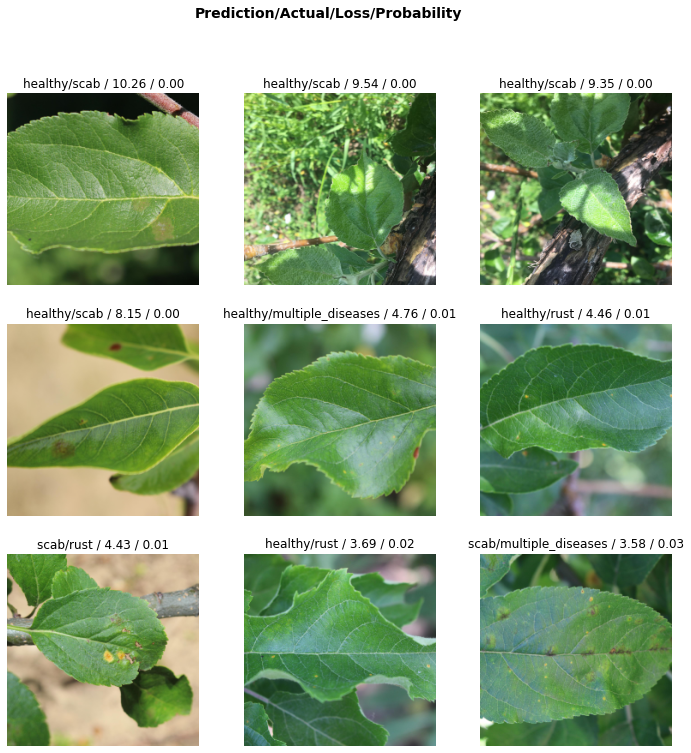

In [0]:
inter = ClassificationInterpretation.from_learner(learn)
losses, idxs = inter.top_losses()
print(len(data.valid_ds) == len(losses) == len(idxs))
inter.plot_top_losses(9)

In [0]:
inter.most_confused(2)

[('scab', 'healthy', 5),
 ('rust', 'multiple_diseases', 4),
 ('multiple_diseases', 'healthy', 3),
 ('multiple_diseases', 'scab', 3),
 ('rust', 'healthy', 3),
 ('healthy', 'scab', 2),
 ('multiple_diseases', 'rust', 2)]

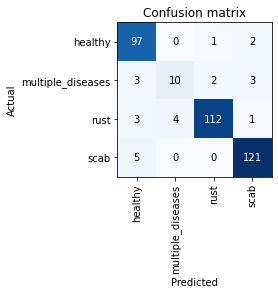

In [0]:
inter.plot_confusion_matrix()

In [0]:
learn.save("stage_2")

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 6.31E-07
Min loss divided by 10: 3.31E-07


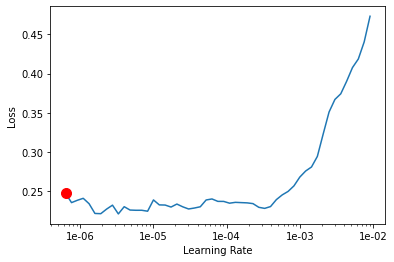

In [0]:
learn.recorder.plot(suggestion=True)

In [0]:
learn.unfreeze()

In [0]:
%%time
learn.fit_one_cycle(2, max_lr=slice(1e-6,2e-6))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.233562,0.249760,0.934066,0.065934,02:19
1,0.225182,0.242712,0.934066,0.065934,02:20


CPU times: user 29.8 s, sys: 19 s, total: 48.9 s
Wall time: 4min 39s


In [0]:
preds, y = learn.get_preds(DatasetType.Test)
preds_np = preds.numpy()
px = pd.DataFrame(preds_np)

In [0]:
submit = pd.read_csv(path_ano/"sample_submission.csv")
submit.healthy = px[0]
submit.multiple_diseases = px[1]
submit.rust = px[2]
submit.scab = px[3]
print(submit.head())
submit.to_csv(path_out/"submission.csv", index = False)

  image_id       healthy  multiple_diseases      rust          scab
0   Test_0  2.734650e-04       1.413456e-02  0.985590  1.840299e-06
1   Test_1  8.256029e-09       5.530757e-04  0.999447  2.599815e-07
2   Test_2  3.661648e-04       4.118733e-05  0.000003  9.995899e-01
3   Test_3  9.999957e-01       9.311595e-10  0.000004  7.811810e-08
4   Test_4  9.565371e-11       4.642427e-06  0.999995  1.887009e-09
